# 04.06 Metro Traffic

Let's look at an example where we perform analysis of a time series.
We will check out some new techniques for plotting and aggregating along the way.
We start with the common suspects.

In [1]:
import numpy as np
import pandas as pd

![Metro Minneapolis](pd-metro.svg)

<div style="text-align:right;"><sup>pd-metro.svg</sup></div>

## The dataset

The [Metro Transit][metro] in Minneapolis has a branch that runs between
the two main cities in Minnesota: Minneapolis and Saint Paul.
It forms the main Metropolitan area of Minnesota.
The branch crosses the Mississippi river on its way.
We will look at traffic data on the ATR $301$ station,
more commonly known as Victoria Street Station.

The dataset has been donated to, and can be downloaded from,
the [Irvine Machine Learning Repository][dataset].
But it has some duplicates, which I have culled before
building the comma separated value (CSV) file we import below.

A full transit dataset can always be downloaded from
the [Minnesota Department of Transport][mndot]
but out dataset has more information that has been added
to the plain traffic data.

[metro]: https://www.openstreetmap.org/#map=13/44.9518/-93.1963
[dataset]: https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume
[mndot]: https://www.dot.state.mn.us/

The `read_csv` procedure in `pandas` is the de facto standard
for data imports in PyData.
NumPy provides the `loadtxt` procedure but `read_csv` can
process missing data and many more flavors of data formats.
Notably, CSV is a badly standardized format,
and some clever heuristics are needed to parse some files.
Moreover, `pandas` can parse the dates in the file automatically.

In [2]:
metro_df = pd.read_csv(
    "pd-metro-traffic.csv",
    index_col="date_time",
    parse_dates=True,
)
metro_df.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
date_time,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40.0,5545
2012-10-02 10:00:00,289.36,0.0,0.0,75.0,4516
2012-10-02 11:00:00,289.58,0.0,0.0,90.0,4767
2012-10-02 12:00:00,290.13,0.0,0.0,90.0,5026
2012-10-02 13:00:00,291.14,0.0,0.0,75.0,4918


We have hourly data on the passenger traffic on the westbound trains:
from Saint Paul to Minneapolis.
We also have a considerable amount of weather data.

For a start let's see what we have.

In [3]:
metro_df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000
mean,281.315882,0.318629,0.000117,44.201215,3290.650474
std,13.817217,48.812640,0.005676,38.681283,1984.772909
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,271.840000,0.000000,0.000000,1.000000,1248.500000
50%,282.860000,0.000000,0.000000,40.000000,3427.000000
75%,292.280000,0.000000,0.000000,90.000000,4952.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


The traffic looks alright, three thousand people per hour is a reasonable number.
The rain and snow data would be quite a lot of work to deal with so we will ignore those.
And the temperature seems alright but a tad off in value.
The temperature is in Kelvin but we will convert it to Celsius because
it is easier to think about temperature in that scale.
We also rename the index to a shorter name.

In [4]:
traffic_df = metro_df[["temp", "traffic_volume"]].copy()
traffic_df.index.name = "date"
traffic_df.columns = ["temp", "traffic"]
traffic_df["temp"] = traffic_df["temp"] - 273
traffic_df

,temp,traffic
date,,
2012-10-02 09:00:00,15.28,5545
2012-10-02 10:00:00,16.36,4516
2012-10-02 11:00:00,16.58,4767
2012-10-02 12:00:00,17.13,5026
2012-10-02 13:00:00,18.14,4918
...,...,...
2018-09-30 19:00:00,10.45,3543
2018-09-30 20:00:00,9.76,2781
2018-09-30 21:00:00,9.73,2159


The data is aggregated by the hour, something that will be important to keep in mind.

We should plot it to get a better understanding.
We will need `matplotlib` configuration.

In [5]:
import matplotlib.pyplot as plt

The `pandas` library wraps over `matplotlib` with its `plot` procedure,
Most arguments are passed directly into `matplotlib` although
there are several exceptions for that behavior.
Whether to use `pandas`, `matplotlib` or a combination of both for plotting
is a personal preference.
Here we will use a combination of both to get some understanding on how they work together.

We have two very distinct pieces of data to plot: traffic volume and temperature.
One can build two separate vertical axes, one on the left another on the right
with `maplotlib`'s `twinx` (there is also `twiny` but far less common).
We then use one of the axes to plot the traffic and another to plot the temperature.
We pass the axis we want to use in the `ax=` argument.

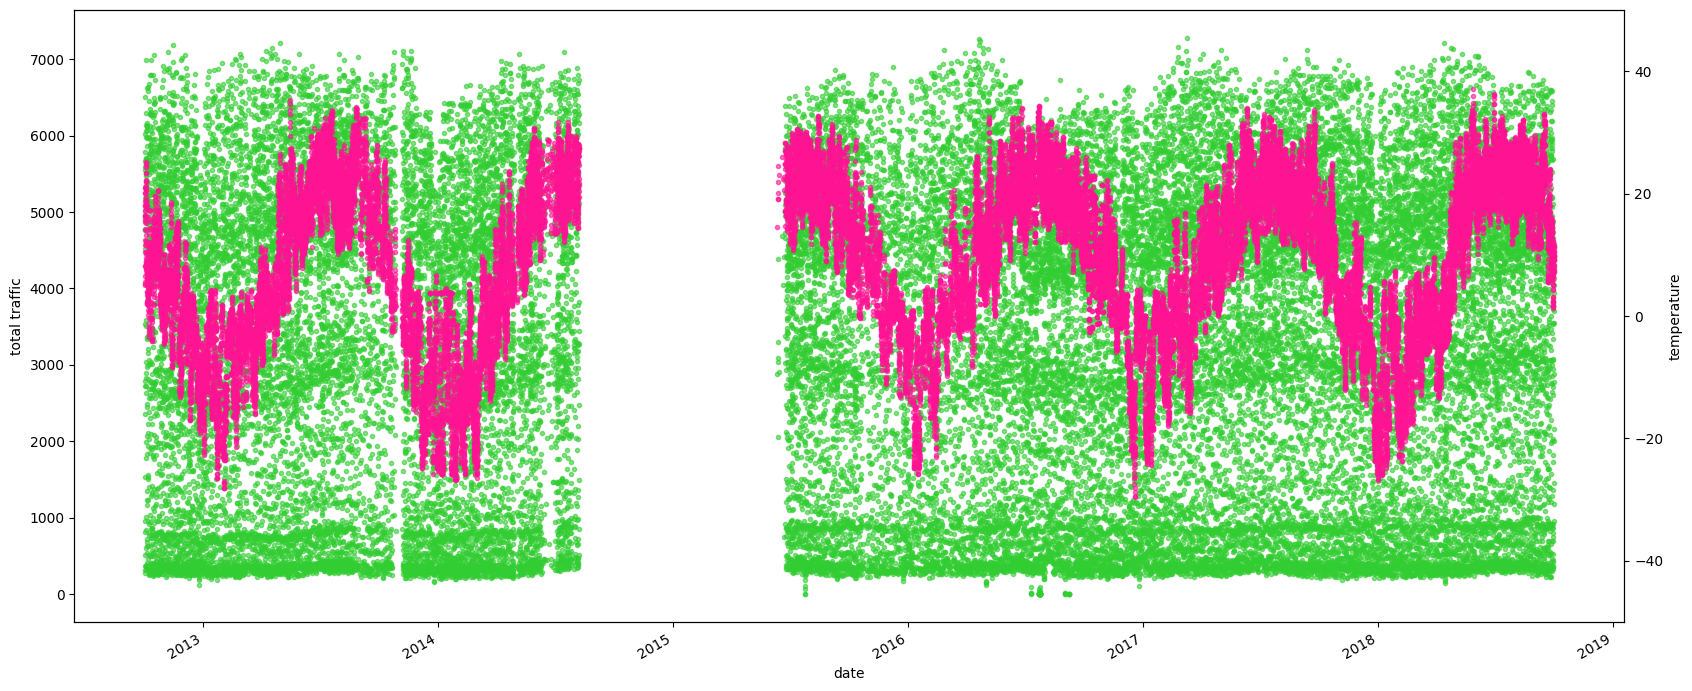

In [6]:
fig, axl = plt.subplots(figsize=(20, 9))
axr = axl.twinx()
traffic_df["traffic"].plot(alpha=0.6, ax=axl, style=".", color="limegreen")
traffic_df["temp"].plot(alpha=0.6, ax=axr, style=".", color="deeppink")
axl.set_ylabel("total traffic")
axr.set_ylim(-50, 50)
axr.set_ylabel("temperature");

This is a good representation of a real dataset,
a good deal of missing data can be seen.
The temperature changes regularly with the year
but we can tell little about the traffic volume.

The data is also too granular.
If we aggregate by week we should see more.
The `resample` procedure will allow us to aggregate on subsets of the time,
here the `W` means week (a period definition in `pandas`).
Before we used a scatter because we had $40$ thousand points,
now we should be able to use lines.

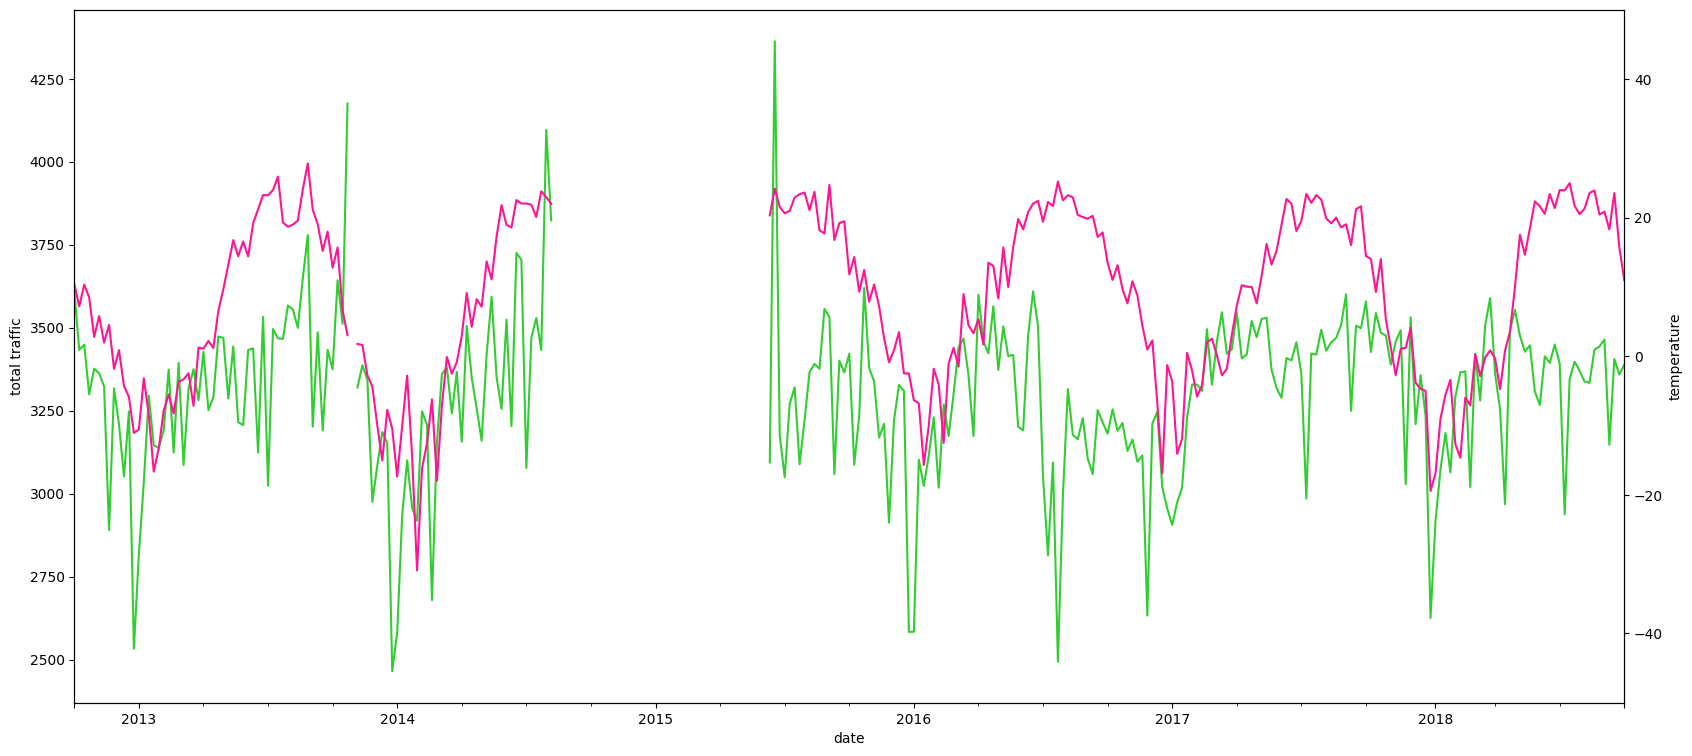

In [7]:
fig, axl = plt.subplots(figsize=(20, 9))
axr = axl.twinx()
weekly = traffic_df.resample("W").mean()
weekly["traffic"].plot(ax=axl, color="limegreen")
weekly["temp"].plot(ax=axr, color="deeppink")
axl.set_ylabel("total traffic")
axr.set_ylim(-50, 50)
axr.set_ylabel("temperature");

We can start to see a pattern here but it is still very rigged.

Another aggregation technique we can use is a rolling window.
A rolling window will aggregate over each period in consideration
with a number of periods close to it.
Here we will take days (using `resample`) and make a rolling window over $30$ days.
Each day will have the mean traffic of itself and $29$ closest days.
The `center=` argument asks for days both in the past and in the future
when aggregating.

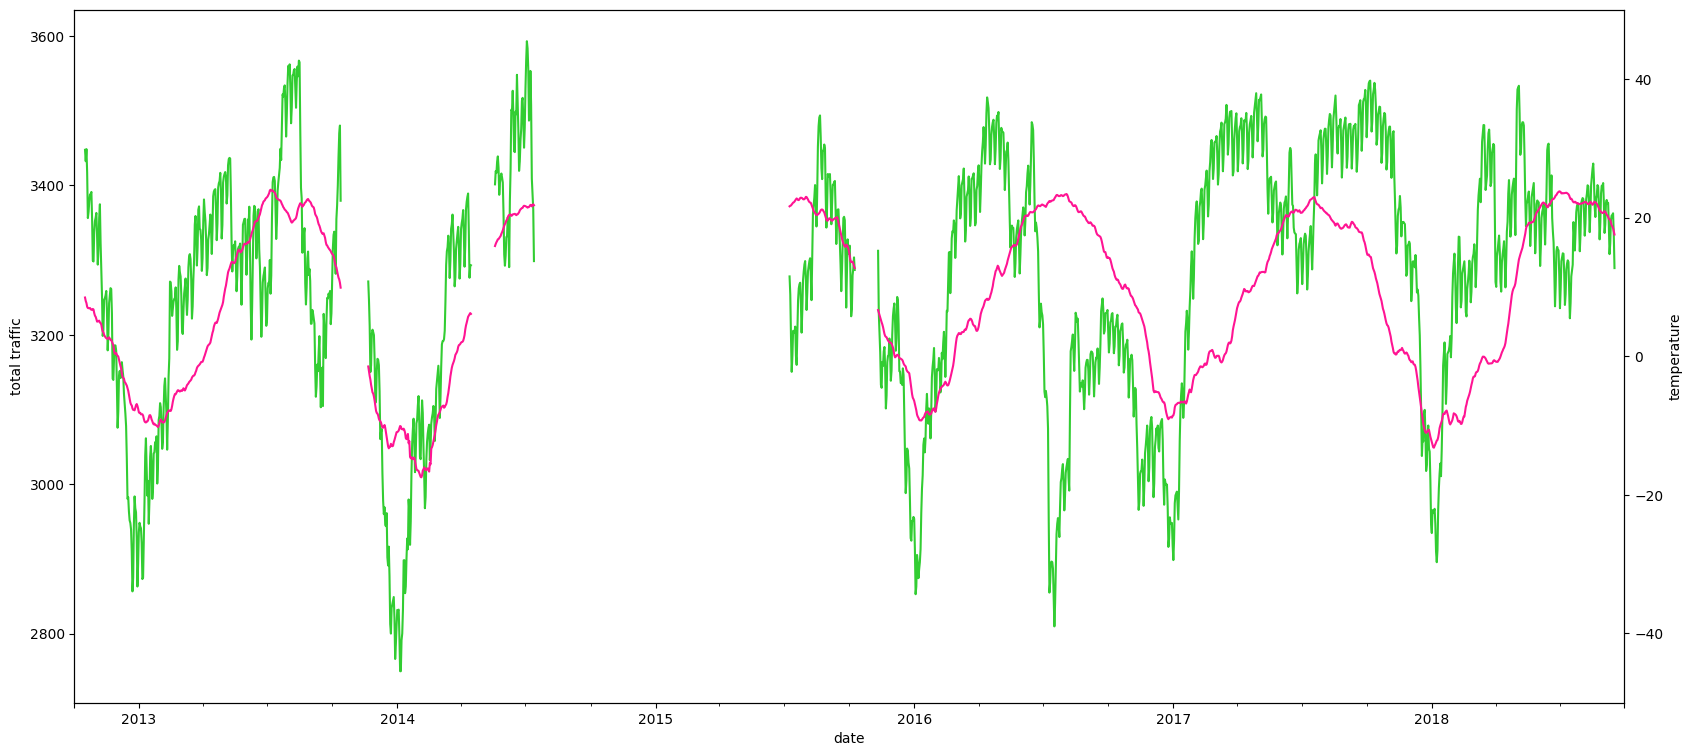

In [8]:
fig, axl = plt.subplots(figsize=(20, 9))
axr = axl.twinx()
daily = traffic_df.resample("D").mean()
daily = daily.rolling(30, center=True).mean()
daily["traffic"].plot(ax=axl, color="limegreen")
daily["temp"].plot(ax=axr, color="deeppink")
axl.set_ylabel("total traffic")
axr.set_ylim(-50, 50)
axr.set_ylabel("temperature");

That's good enough.  The rolling window flattens the noise.
The only thing we could improve towards a presentation of the graph is the number of points.

Above every day is still a single point on the graph,
we could smoothen it by making a window over $5$ weeks instead of $30$ days.
For an even smoother curve we could do a rolling window over $10$ weeks.

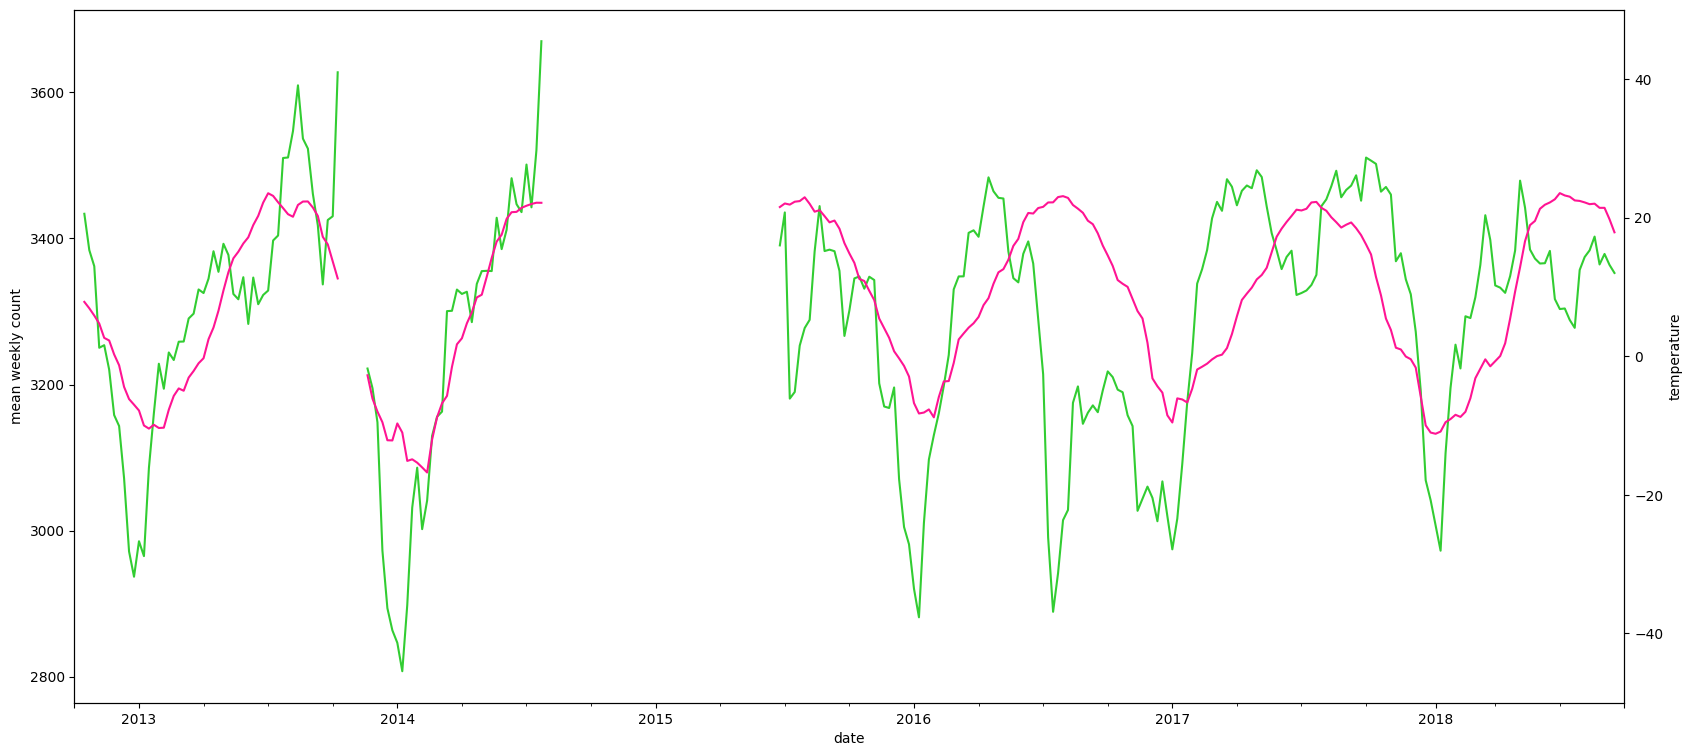

In [9]:
fig, axl = plt.subplots(figsize=(20, 9))
axr = axl.twinx()
weekly = traffic_df.resample("W").mean()
weekly = weekly.rolling(5, center=True).mean()
weekly["traffic"].plot(ax=axl, color="limegreen")
weekly["temp"].plot(ax=axr, color="deeppink")
axl.set_ylabel("mean weekly count")
axr.set_ylim(-50, 50)
axr.set_ylabel("temperature");

In the initial graph we could only see a mesh of points.
Here we can see some patterns:
The usage of the metro decreases during the holiday period,
and during a short period in the summer.

What we have been doing with the resampling
was a from of grouping and then aggregating.
We did the grouping of times close to each other
but grouping of things away from each other is also possible and useful.

### Group By

On a time series *grouping by* can produce completely different time frames,
known as dicing and slicing the frame.
On dates and times this division is quite evident: each day is formed of hours,
each hour of minutes and so on.
Let's first try to get a series of time stamps
from our data and see how we can divide it into divisions such as weeks, days or hours.

In [10]:
series = traffic_df.index.to_series()
series

date
2012-10-02 09:00:00   2012-10-02 09:00:00
2012-10-02 10:00:00   2012-10-02 10:00:00
2012-10-02 11:00:00   2012-10-02 11:00:00
2012-10-02 12:00:00   2012-10-02 12:00:00
2012-10-02 13:00:00   2012-10-02 13:00:00
                              ...        
2018-09-30 19:00:00   2018-09-30 19:00:00
2018-09-30 20:00:00   2018-09-30 20:00:00
2018-09-30 21:00:00   2018-09-30 21:00:00
2018-09-30 22:00:00   2018-09-30 22:00:00
2018-09-30 23:00:00   2018-09-30 23:00:00
Name: date, Length: 40575, dtype: datetime64[ns]

We know a year has $365$ or $366$ days,
which makes it $8760$ or $8784$ hours during a year.

Knowing this we can check how much missing data we have each year.

In [11]:
series.groupby(series.dt.year).count()

date
2012    2103
2013    7294
2014    4501
2015    3593
2016    7838
2017    8713
2018    6533
Name: date, dtype: int64

Not a single complete year.
Let us look at $2015$ and see how many days we actually have.

In [12]:
s2015 = series["2015"]
s2015.groupby(s2015.dt.year).count() / 24

date
2015    149.708333
Name: date, dtype: float64

Less than $150$ days is not much to go about.
Thankfully the other years are better.

Now, one common pitfall to evaluate missing data in time series is to use the `info`
procedure or the `isnull` procedure.

In [13]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40575 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   temp     40575 non-null  float64
 1   traffic  40575 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 951.0 KB


Both `info` and `isnull` will tell us that there are no nulls.
That is correct, there are no nulls.
But a time series defines an initial time and a final time,
and any points missing in the middle or not appearing at all is missing data.
This also means that dropping missing data in a time series
is a rather meaningless operation.

## Traffic Patterns

Knowing about grouping by we can slice the data in more ways now.
Remember that several of the properties of the `dt` object are directly available from the index.
For example, grouping by time (we only have hours) we can get the mean hourly traffic.
Note the hourly ticks we setup in order to make a readable graph.

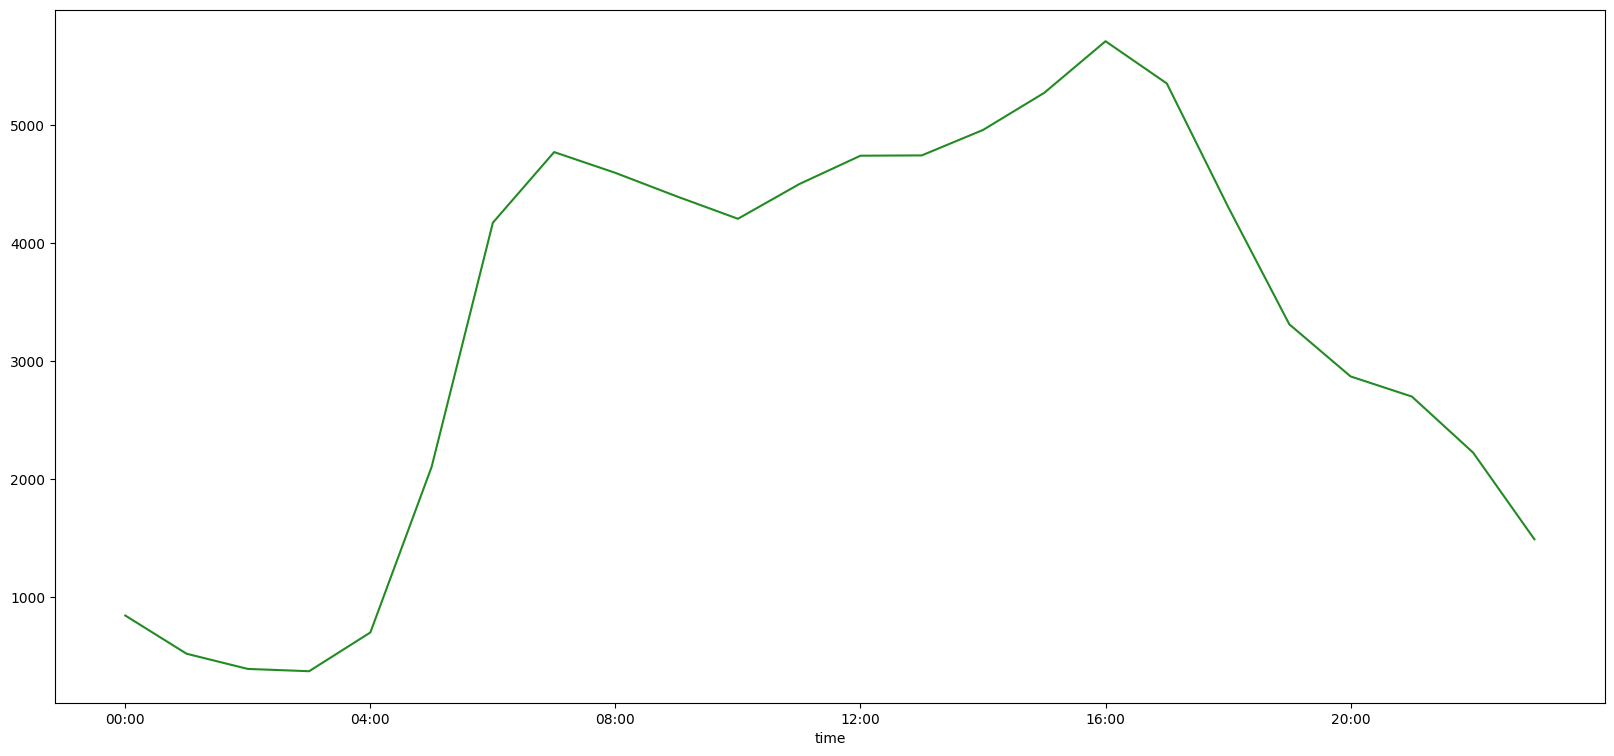

In [14]:
fig, ax = plt.subplots(figsize=(20, 9))
by_time = traffic_df["traffic"].groupby(traffic_df.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, ax=ax, color="forestgreen");

Well, yeah, those are people riding to work and riding back home.

Grouping by the day of the week we get the amount of traffic across weekdays.
Again, we set ticks to get a nice graph.

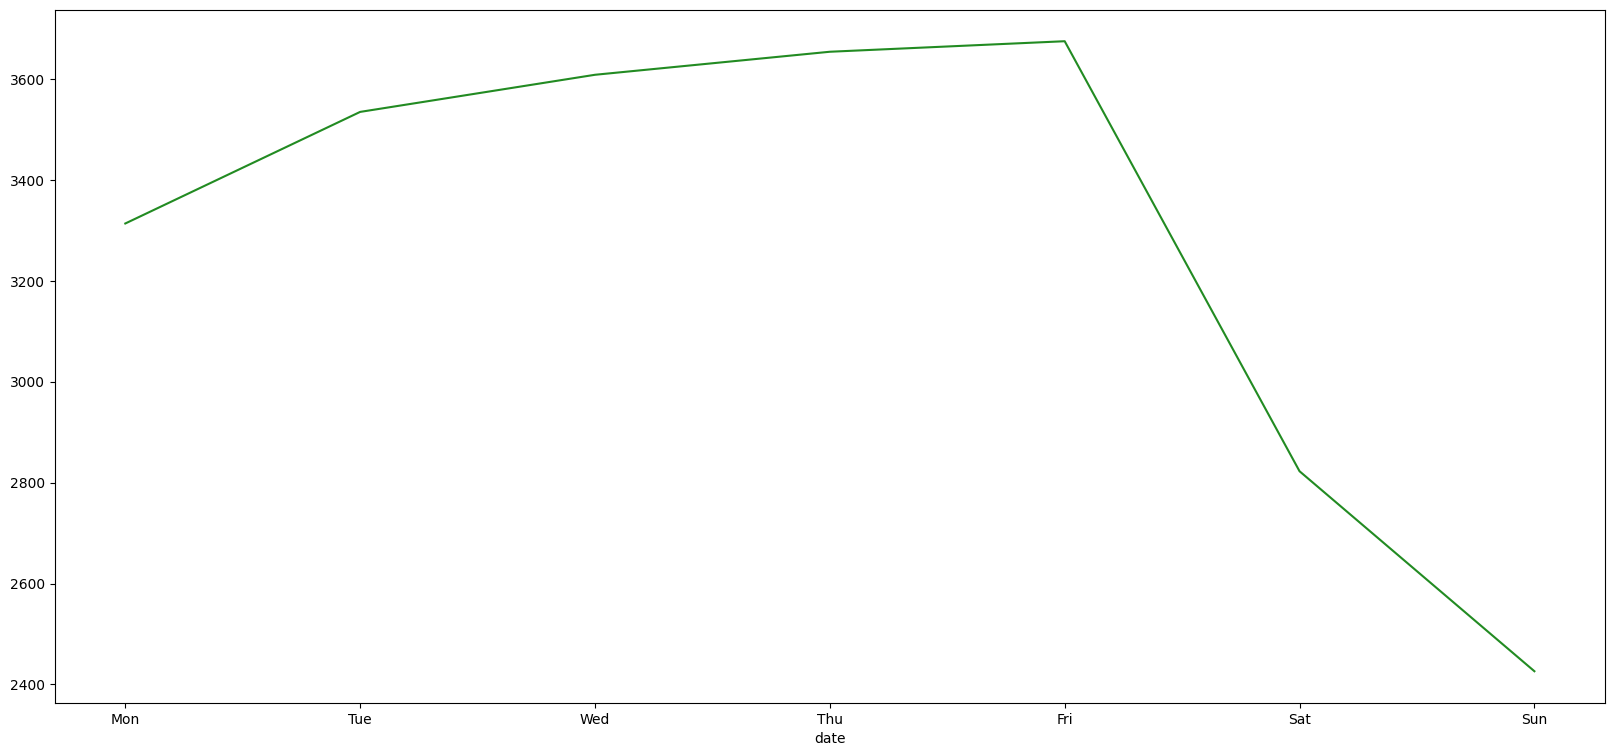

In [15]:
fig, ax = plt.subplots(figsize=(20, 9))
by_weekday = traffic_df["traffic"].groupby(traffic_df.index.dayofweek).mean()
weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
by_weekday.plot(xticks=np.arange(len(weekdays)), ax=ax, color="forestgreen")
ax.set_xticklabels(weekdays);

The weekend is very different, as we'd expect.
We can also check how the hourly distribution is on the weekend.
We can build a multi-index by *grouping by* over two elements.

Remember that the `where` procedure from NumPy works similar to an if-else loop.
Also, `weekday` is an alias for `dayoftheweek`, as well as `day_name`.
`pandas` often has aliases for the same attribute.

In [16]:
weekend = np.where(traffic_df.index.weekday < 5, "Weekday", "Weekend")
by_time = traffic_df["traffic"].groupby([weekend, traffic_df.index.time]).mean()
by_time

Weekday  00:00:00     655.215559
         01:00:00     400.186161
         02:00:00     303.099343
         03:00:00     362.868003
         04:00:00     830.107084
         05:00:00    2699.254804
         06:00:00    5375.273780
         07:00:00    6061.162458
         08:00:00    5508.896580
         09:00:00    4900.601709
         10:00:00    4400.511513
         11:00:00    4663.444724
         12:00:00    4873.933775
         13:00:00    4879.508446
         14:00:00    5182.139324
         15:00:00    5629.210084
         16:00:00    6240.881967
         17:00:00    5822.880068
         18:00:00    4485.019056
         19:00:00    3332.081193
         20:00:00    2877.224039
         21:00:00    2701.767594
         22:00:00    2149.272431
         23:00:00    1404.371084
Weekend  00:00:00    1323.411043
         01:00:00     817.800403
         02:00:00     620.313152
         03:00:00     399.438559
         04:00:00     381.582822
         05:00:00     642.768443
         0

This resulted in a series with a two-level index,
weekday of weekend and the hours.
Now one can select from the first index and plot each piece of data side to side.

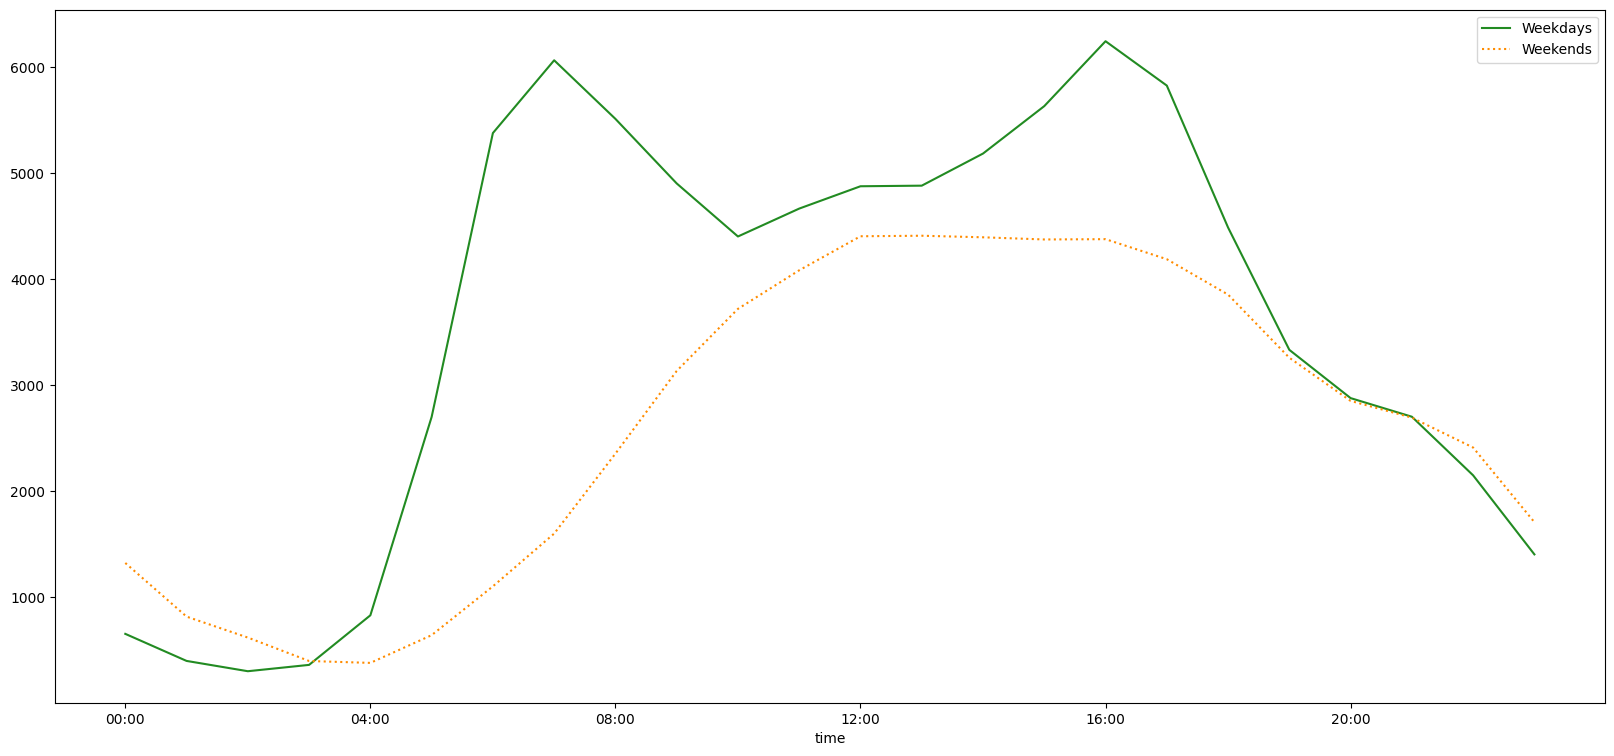

In [17]:
fig, ax = plt.subplots(figsize=(20, 9))
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.loc["Weekday"].plot(
    ax=ax, label="Weekdays", style="-", color="forestgreen"
)
by_time.loc["Weekend"].plot(
    ax=ax, label="Weekends", style=":", color="darkorange"
)
ax.legend()
ax.set_xticks(hourly_ticks);

The weekday behavior of riding to work and riding home is even more pronounced.
But during the weekend we see a very different pattern.

## References and Extras

[Group by - pandas user guide][1]

[1]: https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html